# Queries, Keys and Values

The essence of an **attention mechanism** is
$$\textrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\textrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$$
with $\mathcal{D} \stackrel{\textrm{def}}{=} \{(\mathbf{k}_1, \mathbf{v}_1), \ldots (\mathbf{k}_m, \mathbf{v}_m)\}$

The weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ can assume various forms:
* they can be nonnegative
* they can be a probability (i.e. *a convex combination*)
* they can be a one-hot encoding
* they can be all equal, in the form $\frac{1}{m}$

A common practice is to take any function $a(\mathbf{q}, \mathbf{k}_i)$ and to apply *softmax*:
$$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a(\mathbf{q}, \mathbf{k}_j))}$$
The properties of the softmax (of its gradient) make it very desirable for deep learning models.

# Visualization

In [1]:
import torch
from d2l import torch as d2l

Convex weights can be interpreted as a way for the model to select components of relevance.\
It is important to point that it is just an intuition.

In [2]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(
        nrows = num_rows,
        ncols = num_cols,
        figsize = figsize,
        sharex = True,
        sharey=True,
        squeeze=False
    )
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap = cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])

    fig.colorbar(pcm, ax=axes, shrink=0.6)

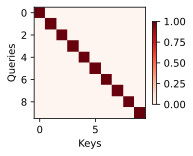

In [3]:
attention_weights = torch.eye(10).reshape(1, 1, 10, 10)
show_heatmaps(
    matrices=attention_weights,
    xlabel='Keys',
    ylabel='Queries'
)

# Attention Pooling by Similarity

Let's try to use attention mechanisms in a regression setting. Check some possible similarity kernels relating queries and key:
$$\begin{split}\begin{aligned}
\alpha(\mathbf{q}, \mathbf{k}) & = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right) && \textrm{Gaussian;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = 1 \textrm{ if } \|\mathbf{q} - \mathbf{k}\| \leq 1 && \textrm{Boxcar;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = \mathop{\mathrm{max}}\left(0, 1 - \|\mathbf{q} - \mathbf{k}\|\right) && \textrm{Epanechnikov.}
\end{aligned}\end{split}$$

The final equation for regression (or classification) would be something like
$$f(\mathbf{q}) = \sum_i \mathbf{v}_i \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{\sum_j \alpha(\mathbf{q}, \mathbf{k}_j)}$$

with $\mathbf{v}_i = y_i$, $\mathbf{k}_i = \mathbf{x}_i$, and the queries are (appropriately) regressions on new points.

In [4]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

# Kernels and Data

All the kernels are translation and rotation invariant. Let's define some kernels:

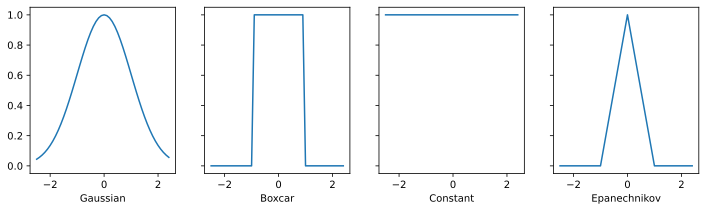

In [6]:
def gaussian(x):
    return torch.exp(-x**2/2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechnikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))


fig, axes = d2l.plt.subplots(
    nrows=1,
    ncols=4,
    sharey=True,
    figsize=(12, 3)
)

kernels = (gaussian, boxcar, constant, epanechnikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechnikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()

Let's set up a function (non - deterministic with $\epsilon \sim Norm(0, 1)$):
$$y_i = 2\sin (x_i) + x_i + \epsilon$$

In [10]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5,  0.1)
y_val = f(x_val)

x_train.reshape((-1, 1))

tensor([[0.0316],
        [0.2753],
        [0.3498],
        [0.4772],
        [0.4834],
        [0.5391],
        [0.5759],
        [0.9385],
        [1.1785],
        [1.2228],
        [1.2274],
        [1.2294],
        [1.2389],
        [1.3619],
        [1.4760],
        [1.6847],
        [2.0511],
        [2.1657],
        [2.3474],
        [2.4128],
        [2.4402],
        [2.7336],
        [2.8093],
        [3.1360],
        [3.2811],
        [3.3598],
        [3.3658],
        [3.5937],
        [3.6386],
        [3.6625],
        [3.6655],
        [3.7526],
        [3.8503],
        [3.8547],
        [3.9781],
        [4.1255],
        [4.3750],
        [4.4295],
        [4.5792],
        [4.8563]])

# Attention Pooling via Nadaraya - Watson Regression

In [15]:
def nadaraya_watson(x_train, y_train, x_val, y_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    print(dists)
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train @ attention_w
    return y_hat, attention_w

tensor([[ 0.0316, -0.0684, -0.1684,  ..., -4.6684, -4.7684, -4.8684],
        [ 0.2753,  0.1753,  0.0753,  ..., -4.4247, -4.5247, -4.6247],
        [ 0.3498,  0.2498,  0.1498,  ..., -4.3502, -4.4502, -4.5502],
        ...,
        [ 4.4295,  4.3295,  4.2295,  ..., -0.2705, -0.3705, -0.4705],
        [ 4.5792,  4.4792,  4.3792,  ..., -0.1208, -0.2208, -0.3208],
        [ 4.8563,  4.7563,  4.6563,  ...,  0.1563,  0.0563, -0.0437]])
tensor([[ 0.0316, -0.0684, -0.1684,  ..., -4.6684, -4.7684, -4.8684],
        [ 0.2753,  0.1753,  0.0753,  ..., -4.4247, -4.5247, -4.6247],
        [ 0.3498,  0.2498,  0.1498,  ..., -4.3502, -4.4502, -4.5502],
        ...,
        [ 4.4295,  4.3295,  4.2295,  ..., -0.2705, -0.3705, -0.4705],
        [ 4.5792,  4.4792,  4.3792,  ..., -0.1208, -0.2208, -0.3208],
        [ 4.8563,  4.7563,  4.6563,  ...,  0.1563,  0.0563, -0.0437]])
tensor([[ 0.0316, -0.0684, -0.1684,  ..., -4.6684, -4.7684, -4.8684],
        [ 0.2753,  0.1753,  0.0753,  ..., -4.4247, -4.5247, -4

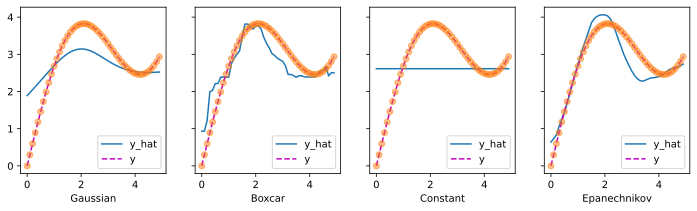

In [17]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fix, axes = d2l.plt.subplots(
        nrows=1,
        ncols=4,
        sharey=True,
        figsize=(12, 3)
    )
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, y_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_val, y_val, 'o', alpha=0.5)
        ax.set_xlabel(name)

        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)